# Extract Relative Pose
This script is used to convert ground truth scripts with absolute poses to relative poses for RPR

In [8]:
import numpy as np
import os
from scipy.spatial.transform import Rotation as R
import pandas as pd

In [9]:
data_root = 'D:/Imperial/FYP/captured_data/airsim_drone_mode/'
airsim_rec_file = 'val/airsim_rec_0.txt'

train_data = pd.read_csv(os.path.join(data_root, airsim_rec_file), sep="\t")
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["prev_timestamp"] = train_data["timestamp"].shift(1)

# Pair poses up with previous frame pose
train_data["prev_POS_X"] = train_data["POS_X"].shift(1)
train_data["prev_POS_Y"] = train_data["POS_Y"].shift(1)
train_data["prev_POS_Z"] = train_data["POS_Z"].shift(1)
train_data["prev_Q_W"] = train_data["Q_W"].shift(1)
train_data["prev_Q_X"] = train_data["Q_X"].shift(1)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(1)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(1)

# Pair poses up with previous velocity, previous acceleration
train_data["prev_LIN_VEL_X"] = train_data["LIN_VEL_X"].shift(1)
train_data["prev_LIN_VEL_Y"] = train_data["LIN_VEL_Y"].shift(1)
train_data["prev_LIN_VEL_Z"] = train_data["LIN_VEL_Z"].shift(1)
train_data["prev_LIN_ACC_X"] = train_data["LIN_ACC_X"].shift(1)
train_data["prev_LIN_ACC_Y"] = train_data["LIN_ACC_Y"].shift(1)
train_data["prev_LIN_ACC_Z"] = train_data["LIN_ACC_Z"].shift(1)

# Calculate timestep from previous frame
train_data["timestep"] = ((train_data["timestamp"] - train_data["prev_timestamp"]).dt.total_seconds())

# Previous frame image filename
train_data['prev_ImageFile'] = train_data['ImageFile'].shift(1)

# Ignore first row as there is no previous frame
train_data = train_data.iloc[1:, :].reset_index()

In [10]:
train_data.head()

,index,Vehicle_name,timestamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,...,prev_Q_Y,prev_Q_Z,prev_LIN_VEL_X,prev_LIN_VEL_Y,prev_LIN_VEL_Z,prev_LIN_ACC_X,prev_LIN_ACC_Y,prev_LIN_ACC_Z,timestep,prev_ImageFile
0,1,,2022-05-13 17:19:11.308151552,-7.468446,-7.286850,-2.804012,0.996271,0.072833,-0.007932,0.045577,...,0.000531,0.000033,0.014244,0.013831,0.051230,-0.011140,-0.010631,-0.177374,0.250484,0.png
1,2,,2022-05-13 17:19:11.561635328,-7.458852,-7.187167,-2.836372,0.969235,0.081477,-0.025924,0.230809,...,-0.007932,0.045577,0.030340,0.282382,-0.050150,0.127642,1.951442,-1.867890,0.253484,1.png
2,3,,2022-05-13 17:19:11.818118912,-7.442213,-6.990725,-2.880651,0.880282,0.057999,-0.037450,0.469400,...,-0.025924,0.230809,0.062854,0.738336,-0.203972,0.121263,1.558641,0.345132,0.256484,2.png
3,4,,2022-05-13 17:19:12.062603264,-7.411184,-6.621276,-2.907853,0.693563,0.028762,-0.035189,0.718961,...,-0.037450,0.469400,0.091505,1.089757,-0.107986,0.098987,1.180840,0.325863,0.244484,3.png
4,5,,2022-05-13 17:19:12.316087040,-7.382303,-6.276911,-2.907947,0.658152,0.019162,-0.025419,0.752212,...,-0.035189,0.718961,0.112073,1.334218,-0.019964,0.068260,0.816425,0.557823,0.253484,4.png


## Calculate Relative Poses

In [11]:
def obtain_relative_pose(absolute_pose_c1, absolute_pose_c2):
	xyz1, wxyz1 = absolute_pose_c1[:3], absolute_pose_c1[3:]
	xyz2, wxyz2 = absolute_pose_c2[:3], absolute_pose_c2[3:]

	# Airsim records quartenion as wxyz but scipy takes in xyzw format
	rot_mat1 = R.from_quat(np.hstack([wxyz1[1:], wxyz1[0]])).as_matrix()
	rot_mat2 = R.from_quat(np.hstack([wxyz2[1:], wxyz2[0]])).as_matrix()

	# Obtain Relative poses
	relative_t = xyz2 - xyz1 
	relative_q = R.from_matrix(np.matmul(np.transpose(rot_mat1), rot_mat2)).as_quat()
	relative_q = np.hstack([relative_q[3:], relative_q[:3]]) # Convert to wxyz format

	return np.hstack([relative_t, relative_q])

train_data["relative_pose"] = train_data.apply(lambda row: 
                                                    obtain_relative_pose(
                                                        np.hstack([row["POS_X"], row["POS_Y"], row["POS_Z"], row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]]), 
                                                        np.hstack([row["prev_POS_X"], row["prev_POS_Y"], row["prev_POS_Z"], row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])
                                                    ), axis=1)

In [12]:
def get_imu_pred_pose(initial_velocity, cur_accel, timestep):
    return initial_velocity * timestep + 1/2 * cur_accel * timestep**2
train_data["imu_rel_POS_X"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_LIN_VEL_X"], row["prev_LIN_ACC_X"], row["timestep"]), axis=1)
train_data["imu_rel_POS_Y"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_LIN_VEL_Y"], row["prev_LIN_ACC_Y"], row["timestep"]), axis=1)
train_data["imu_rel_POS_Z"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_LIN_VEL_Z"], row["prev_LIN_ACC_Z"], row["timestep"]), axis=1)

# def integrate_angular_velocity(row):
# 	return rowan.calculus.integrate(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
# 							 np.hstack([row["ANG_VEL_X"],row["ANG_VEL_Y"], row["ANG_VEL_Z"]]), row["timestep"])

# train_data["imu_rel_Q_W"] = train_data.apply(lambda row: integrate_angular_velocity(row)[0], axis=1)
# train_data["imu_rel_Q_X"] = train_data.apply(lambda row: integrate_angular_velocity(row)[1], axis=1)
# train_data["imu_rel_Q_Y"] = train_data.apply(lambda row: integrate_angular_velocity(row)[2], axis=1)
# train_data["imu_rel_Q_Z"] = train_data.apply(lambda row: integrate_angular_velocity(row)[3], axis=1)

## Check Distribution

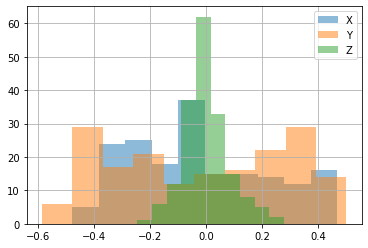

In [13]:
import matplotlib.pyplot as plt

plt.hist(np.vstack(train_data["relative_pose"])[:,0], label="X", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,1], label="Y", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,2], label="Z", alpha=0.5)
plt.legend()
plt.grid()

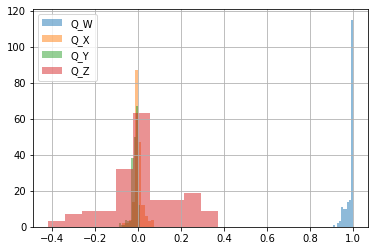

In [14]:
plt.hist(np.vstack(train_data["relative_pose"])[:,3], label="Q_W", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,4], label="Q_X", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,5], label="Q_Y", alpha=0.5)
plt.hist(np.vstack(train_data["relative_pose"])[:,6], label="Q_Z", alpha=0.5)
plt.legend()
plt.grid()

## Write to text file

In [15]:
relative_poses = pd.DataFrame(train_data["relative_pose"].to_list(), columns=["rel_POS_X", "rel_POS_Y", "rel_POS_Z", "rel_Q_W", "rel_Q_X","rel_Q_Y","rel_Q_Z"])
train_data = pd.concat([train_data, relative_poses], axis=1)

In [18]:
train_data = train_data[["ImageFile", "prev_ImageFile", 
                         "prev_LIN_VEL_X", "prev_LIN_VEL_Y", "prev_LIN_VEL_Z", "prev_LIN_ACC_X", "prev_LIN_ACC_Y", "prev_LIN_ACC_Z", "timestep",
                         "rel_POS_X", "rel_POS_Y", "rel_POS_Z", "rel_Q_W", "rel_Q_X","rel_Q_Y","rel_Q_Z",
                         "imu_rel_POS_X", "imu_rel_POS_Y", "imu_rel_POS_Z"
                         ]]
train_data.to_csv(os.path.join(data_root, 'val.txt'), header=True, index=None, sep=' ', mode='w')

In [17]:
train_data.head()

,ImageFile,prev_ImageFile,prev_LIN_VEL_X,prev_LIN_VEL_Y,prev_LIN_VEL_Z,prev_LIN_ACC_X,prev_LIN_ACC_Y,prev_LIN_ACC_Z,timestep,rel_POS_X,rel_POS_Y,rel_POS_Z,rel_Q_W,rel_Q_X,rel_Q_Y,rel_Q_Z,imu_rel_POS_X,imu_rel_POS_Y,imu_rel_POS_Z
0,1.png,0.png,0.014244,0.013831,0.051230,-0.011140,-0.010631,-0.177374,0.250484,-0.003143,-0.011015,-0.020022,0.996231,-0.073312,0.008486,-0.045579,0.003218,0.003131,0.007268
1,2.png,1.png,0.030340,0.282382,-0.050150,0.127642,1.951442,-1.867890,0.253484,-0.009593,-0.099684,0.032360,0.982280,-0.011230,0.005042,-0.187016,0.011791,0.134273,-0.072722
2,3.png,2.png,0.062854,0.738336,-0.203972,0.121263,1.558641,0.345132,0.256484,-0.016640,-0.196442,0.044279,0.967239,0.011983,-0.011381,-0.253330,0.020110,0.240638,-0.040963
3,4.png,3.png,0.091505,1.089757,-0.107986,0.098987,1.180840,0.325863,0.244484,-0.031029,-0.369449,0.027203,0.950998,0.004500,-0.023196,-0.308293,0.025330,0.301719,-0.016662
4,5.png,4.png,0.112073,1.334218,-0.019964,0.068260,0.816425,0.557823,0.253484,-0.028881,-0.344365,0.000094,0.998726,-0.002555,-0.013388,-0.048578,0.030602,0.364432,0.012861


## Check Reverse Calculation to obtain absolute pose

In [19]:
def obtain_absolute_pose(absolute_pose_c2, relative_pose):
	xyz2, wpqr2 = absolute_pose_c2[:3], absolute_pose_c2[3:]
	xyz_rel, wpqr_rel = relative_pose[:3], relative_pose[3:]
	rot_mat2 = R.from_quat(np.hstack([wpqr2[1:], wpqr2[0]])).as_matrix()
	rot_mat_rel = R.from_quat(np.hstack([wpqr_rel[1:], wpqr_rel[0]])).as_matrix()
	t1 = xyz2 - xyz_rel 
	r1 = R.from_matrix(np.matmul(rot_mat2,np.linalg.inv(rot_mat_rel))).as_quat()
	r1 = np.hstack([r1[3:], r1[:3]])
	return np.hstack([t1, r1])

absolute_pose_c1 = train_data.apply(lambda row: np.hstack([row["POS_X"], row["POS_Y"], row["POS_Z"], row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]]), axis=1)
reverse_calculated = train_data.apply(lambda row: 
                                        obtain_absolute_pose(
                                            np.hstack([row["prev_POS_X"], row["prev_POS_Y"], row["prev_POS_Z"], row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
                                            row["relative_pose"]
                                        ), axis=1)

KeyError: 'POS_X'

In [ ]:
print(absolute_pose_c1.iloc[0] == reverse_calculated.iloc[0])

In [ ]:
absolute_pose_c1.iloc[2],reverse_calculated.iloc[2]